### Part Of Speech Tagging using stanza

<A HREF="https://stanfordnlp.github.io/stanza/">Stanford NLP Stanza</A>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import stanza
from collections import defaultdict

In [5]:
# Trying to avoid memory errors here, may cause problems, don't run unless errors occur
#                                     in which case it may be too late anyway.
# import os
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:<512>"

In [6]:
# Download English model (about 561MB). Downloads from huggingface
stanza.download('en')

2023-04-10 13:42:02 INFO: Downloading default packages for language: en (English) ...


2023-04-10 13:42:44 INFO: Finished downloading models and saved to /home/muddy/stanza_resources.


In [7]:
# Initialize English neural pipeline
nlp = stanza.Pipeline('en', processors='tokenize, lemma, pos')

# Full list of processors.... only need tokenize and pos for now
#============================
#| Processor    | Package   |
#----------------------------
#| tokenize     | combined  |
#| pos          | combined  |
#| lemma        | combined  |
#| depparse     | combined  |
#| sentiment    | sstplus   |
#| constituency | wsj       |
#| ner          | ontonotes |
#============================

2023-04-10 13:42:44 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-04-10 13:42:44 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |

2023-04-10 13:42:44 INFO: Using device: cpu
2023-04-10 13:42:44 INFO: Loading: tokenize
2023-04-10 13:42:44 INFO: Loading: pos
2023-04-10 13:42:45 INFO: Loading: lemma
2023-04-10 13:42:45 INFO: Done loading processors!


In [8]:
# Load the two data sets needed

facetPlotData = pd.read_csv('facetPlotData.csv')
df = pd.read_csv('fullEmotionData.csv', encoding='utf_8') # apostrophes aren't being read correctly
# Pandas reads date as string, cast to datetime object
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
facetPlotData['date'] = pd.to_datetime(facetPlotData['date'], format='%Y-%m-%d')
facetPlotData.shape # Should be (3000, 4) 

(3000, 4)

In [9]:
# doc output looks like this.  Everything is labeled, including punctuation!
{
      "id": 1,
      "text": "Thank",
      "lemma": "thank",
      "upos": "VERB",
      "xpos": "VBP",
      "feats": "Mood=Ind|Number=Sing|Person=1|Tense=Pres|VerbForm=Fin",
      "head": 0,
      "deprel": "root",
      "start_char": 0,
      "end_char": 5,
      "ner": "O",
      "multi_ner": [
        "O"
      ]
    }

{'id': 1,
 'text': 'Thank',
 'lemma': 'thank',
 'upos': 'VERB',
 'xpos': 'VBP',
 'feats': 'Mood=Ind|Number=Sing|Person=1|Tense=Pres|VerbForm=Fin',
 'head': 0,
 'deprel': 'root',
 'start_char': 0,
 'end_char': 5,
 'ner': 'O',
 'multi_ner': ['O']}

In [10]:
def cumulative_count(items):
    '''items: list of objects to count
       returns: dictionary with key:item, value: cumulative count of each item'''
    counts = defaultdict(int)
    cumulative_counts = {}
    cumulative_count = 0
    
    for item in items:
        counts[item] += 1
        cumulative_count += 1
        cumulative_counts[item] = cumulative_count
        
    return(cumulative_counts)

In [11]:
# Sepecify source: oba, nyt, wsj
source = 'wsj'

In [12]:
# OK Lets put it all together and loop over all speeches and count up the POS
# The nlp(text) uses a lot of gpu memory, causes errors sometimes, may need to restart notebook to freshen things up
pos_dicts = []
for text in df['text_'+source]:
    doc = nlp(text) # Run stanza on each speech
    mat_of_pos = [[word.pos for word in sentence.words] for sentence in doc.sentences] # matrix of POS for each sentence
    # How to flatten a list = [item for sublist in list_of_lists for item in sublist]
    list_of_pos = [pos for sentence in mat_of_pos for pos in sentence] # flatten matrix into one list of all pos
    pos_counts = cumulative_count(list_of_pos) # get dictionary with key: pos, value: count of that POS in speech
    pos_dicts.append(pos_counts) # list of dictionaries, one dict for each speech

In [13]:
# Make a list of all the unique POS over all the dictionaries, then will make a row in df for each
unique_pos = list(set(key for dict in pos_dicts for key in dict.keys()))

In [14]:
# use unique_pos list to create new columns in df
for col in unique_pos:
    df[source+'_'+col] = 0
    
for i in range(len(df)):
    sum1 = sum(pos_dicts[i].values())
    for key, value in pos_dicts[i].items():
        proportion = value/sum1
        df[source+'_'+key][i] = proportion
df.fillna(value=0); # ; will supress list of whole dataframe

/tmp/ipykernel_45825/2872237280.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[source+'_'+key][i] = proportion


In [15]:
df.head(1)

,file,text_oba,text_wsj,text_nyt,emo_oba,emo_nyt,emo_wsj,date,obafear,obaanger,...,wsj_NOUN,wsj_INTJ,wsj_PROPN,wsj_ADP,wsj_AUX,wsj_SCONJ,wsj_PART,wsj_PUNCT,wsj_SYM,wsj_CCONJ
0,2008-06-04-ObamaNomination.txt,Thank you....Thank you. What a -- What a wonde...,Sen. Barack Obama captured enough convention d...,Senator Barack Obama claimed the Democratic pr...,<nrclex.NRCLex object at 0x7f09f2a0eda0>,<nrclex.NRCLex object at 0x7f09e5416260>,<nrclex.NRCLex object at 0x7f09e2782260>,2008-06-04,0.095798,0.055462,...,0.072581,0.0,0.072183,0.071266,0.072023,0.07031,0.072063,0.072621,0.0,0.072422


In [16]:
# Write the df quickly, before memory errors creep in again.
# Now have POS variables with proportion of each POS for each speech
#df.to_csv('fullEmotionPOSData.csv', encoding='utf_8')

In [17]:
list(df)

['file',
 'text_oba',
 'text_wsj',
 'text_nyt',
 'emo_oba',
 'emo_nyt',
 'emo_wsj',
 'date',
 'obafear',
 'obaanger',
 'obatrust',
 'obasurprise',
 'obapositive',
 'obanegative',
 'obasadness',
 'obadisgust',
 'obajoy',
 'obaanticipation',
 'nytfear',
 'nytanger',
 'nyttrust',
 'nytsurprise',
 'nytpositive',
 'nytnegative',
 'nytsadness',
 'nytdisgust',
 'nytjoy',
 'nytanticipation',
 'wsjfear',
 'wsjanger',
 'wsjtrust',
 'wsjsurprise',
 'wsjpositive',
 'wsjnegative',
 'wsjsadness',
 'wsjdisgust',
 'wsjjoy',
 'wsjanticipation',
 'wsj_DET',
 'wsj_VERB',
 'wsj_ADJ',
 'wsj_PRON',
 'wsj_ADV',
 'wsj_NUM',
 'wsj_NOUN',
 'wsj_INTJ',
 'wsj_PROPN',
 'wsj_ADP',
 'wsj_AUX',
 'wsj_SCONJ',
 'wsj_PART',
 'wsj_PUNCT',
 'wsj_SYM',
 'wsj_CCONJ']

In [18]:
corr_matrix = df[df.columns[pd.Series(df.columns).str.startswith('oba')]].corr().round(3)

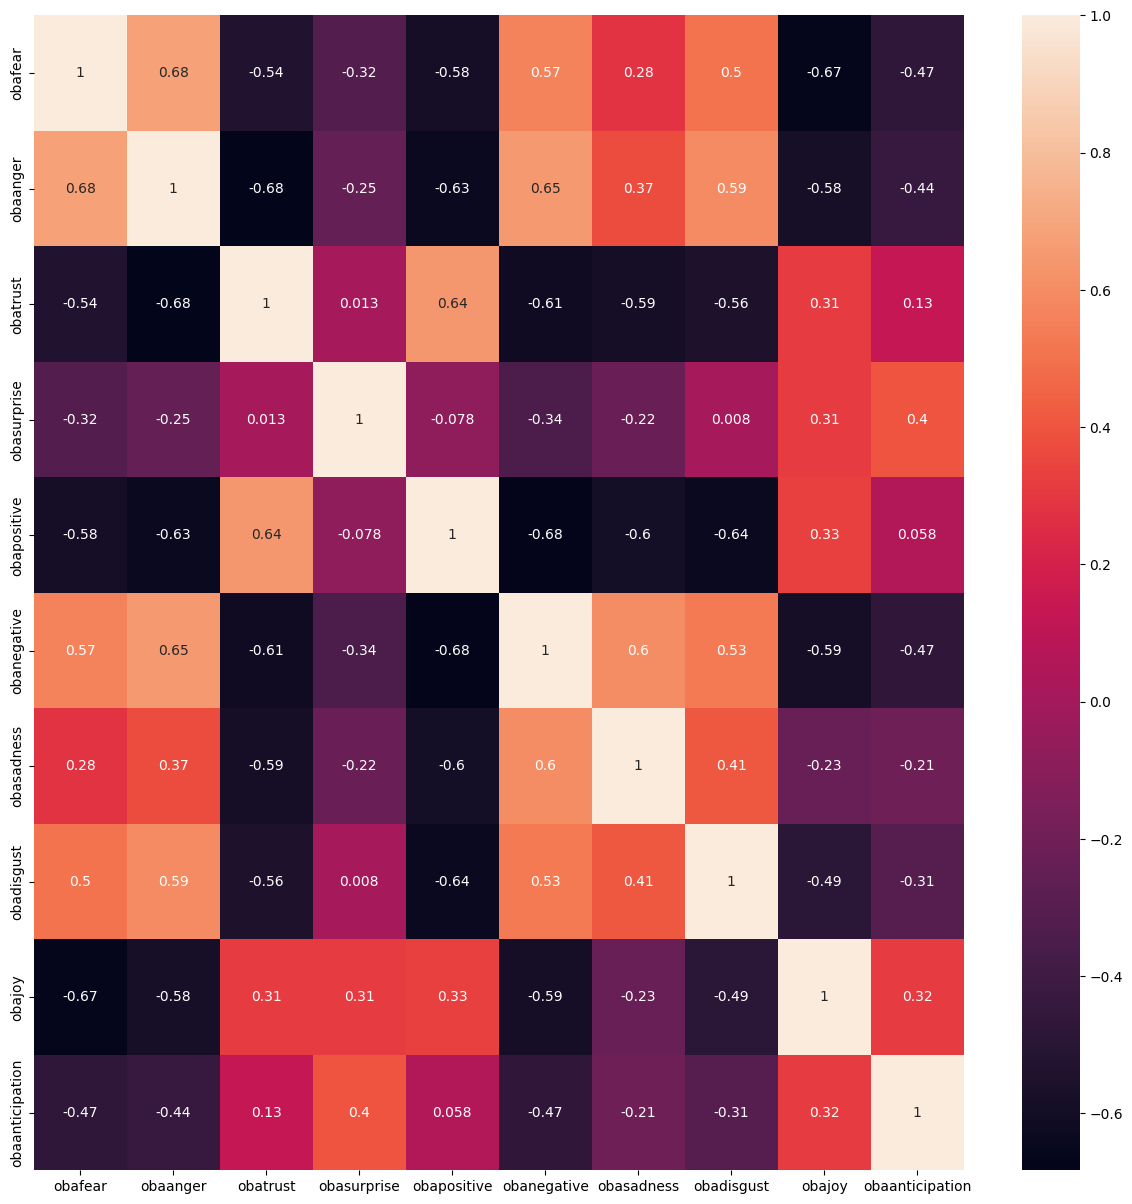

In [19]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [20]:
corr_matrix[abs(corr_matrix)>=0.5]
# Note: None of the POS proportions correlate with the NRC emotion analysis values

,obafear,obaanger,obatrust,obasurprise,obapositive,obanegative,obasadness,obadisgust,obajoy,obaanticipation
obafear,1.000,0.679,-0.536,NaN,-0.585,0.566,NaN,0.502,-0.665,NaN
obaanger,0.679,1.000,-0.683,NaN,-0.633,0.649,NaN,0.595,-0.582,NaN
obatrust,-0.536,-0.683,1.000,NaN,0.642,-0.614,-0.590,-0.556,NaN,NaN
obasurprise,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
obapositive,-0.585,-0.633,0.642,NaN,1.000,-0.675,-0.596,-0.636,NaN,NaN
obanegative,0.566,0.649,-0.614,NaN,-0.675,1.000,0.599,0.530,-0.586,NaN
obasadness,NaN,NaN,-0.590,NaN,-0.596,0.599,1.000,NaN,NaN,NaN
obadisgust,0.502,0.595,-0.556,NaN,-0.636,0.530,NaN,1.000,NaN,NaN
obajoy,-0.665,-0.582,NaN,NaN,NaN,-0.586,NaN,NaN,1.000,NaN
obaanticipation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [21]:
# Reshape data for faceted plots
# check column names - df[df.columns[pd.Series(df.columns).str.startswith('oba')]]
sources = ['oba', 'nyt', 'wsj']
POSFacetPlotData  = pd.DataFrame(columns=['date', 'source', 'pos', 'proportion'])

for i in range(len(df)):
    for source in sources:
        for pos in unique_pos:
            POSFacetPlotData.loc[len(POSFacetPlotData)] = [df['date'].iloc[i], source, pos, df[source+'_'+pos].iloc[i]]
            
POSFacetPlotData['date'] = pd.to_datetime(POSFacetPlotData['date'])
POSFacetPlotData.shape # Should be (4800, 4) 

KeyError: 'oba_DET'

In [ ]:
# Save it!
#POSFacetPlotData.to_csv('POSFacetPlotData')

In [ ]:
# Give it 15ish seconds or so
# <seaborn.axisgrid.FacetGrid at 0x7efac9f911b0> comes up after about 10 seconds, the plots will follow later
times = facetPlotData.date.unique()
g = sns.FacetGrid(facetPlotData, col="source", row="pos", height=6, aspect=2.5)
g.map(sns.barplot, "date", "proportion", errorbar=None, order=times)
plt.show()

In [ ]:
g.savefig("pos_facet_plot.png", bbox_inches="tight", dpi=300)